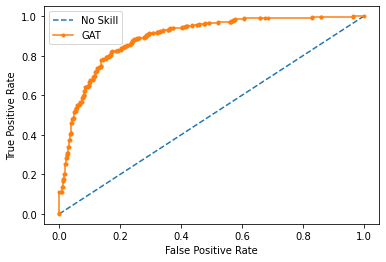

Best Threshold=0.243827, G-Mean=0.825


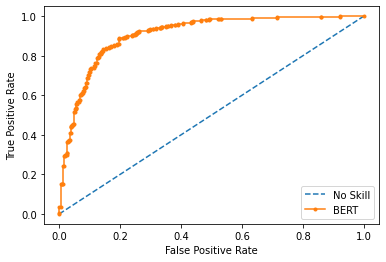

Best Threshold=0.692322, G-Mean=0.845


In [1]:
#use ROC to get optimal cutoff for GAT and RoBERTa respectively
#In this notebook, "pos" or "postive" actually represent "non_negative"
#this is only for class neg VS non-neg
#without using k-fold validation, only select a fixed validation set
#Run this block before running any following block
path_result='C:\\Backup of covid project\\2cls_negVSnonneg\\results\\'
path_data="C:\\Backup of covid project\\2cls_negVSnonneg\\data\\"
path_code="C:\\Backup of covid project\\"

import numpy as np 
import urllib.request 
import os 
import csv 
import requests 
import time
import math
import rando
import pandas as pd
from collections import defaultdict
import pickle
import re, string, unicodedata
import nltk
import contractions
import inflect
import heapq
import pickle
import warnings
import random
from sklearn.utils import shuffle

filepath=path_result
filepath2=path_data
filepath3=path_data
path=path_data
os.chdir(filepath)

types=["comment"]
years=['2019','2020']
#years=['2020']
schools = ["notredame","uofm","columbia","UCSD","berkeley","Harvard","ucla"]
categ={"notredame":[1,1,1],"uofm":[1,1,0],"columbia":[1,0,1],"dartmouth":[0,1,1],
       "UCSD":[1,0,0],"berkeley":[0,1,0],"Harvard":[0,0,1],"ucla":[0,0,0]}

#non-Neg: 1, negative:0
#2020:1, 2019:0
label_group=["label"]#,"unlabel"]
months=['08','09','10','11']

att_com=['time','id','body','Emotion','emo_pred']
drop_com=["link_id",'Topic',"parent_id","author_fullname","author","gildings","score","subreddit","no_follow","total_awards_received","all_awardings","is_submitter","locked","send_replies","stickied",]
emo=["Very Positive","Positive","Neutral","Negative","Very negative"]
top=["Covid","Academics","Sports","Campus/Students Life","Social Media","Religion","Politics","Others"]

TP_HAN=[]
TN_HAN=[]
CR_HAN=[]
Pre_HAN=[]
Rec_HAN=[]
Spe_HAN=[]

TP_BERT=[]
TN_BERT=[]
CR_BERT=[]
Pre_BERT=[]
Rec_BERT=[]
Spe_BERT=[]

df = pd.DataFrame(columns = ['body','Emotion','predicted_HAN_neg','predicted_HAN_pos','predicted_BERT_neg','predicted_BERT_pos','truth_label','truth_rand','schoolyear'])
#Positive: 1, negative:0
for t in types:
    for s in schools:
        for y in years:
            for l in label_group:
                f=s+y+'.p'
                os.chdir(path_result)
                predicted=pickle.load(open(f,'rb'))
                from scipy.special import softmax
                m=softmax(predicted,axis=1)
                pred_HAN=m

                f=s+t+y+'label_score.csv'
                os.chdir(path_data)
                predicted=pd.read_csv(f,skip_blank_lines=True)
                predicted=predicted[['emo_pred_neg','emo_pred_pos']].values
                for i in range(len(predicted)):
                    p0=predicted[i,0]
                    #p1=predicted[i,1]
                    #predicted[i,0]=p0/(p0+p1)
                    predicted[i,1]=1-p0
                pred_BERT=predicted

                f=s+t+y+l+".csv"
                os.chdir(path_data)
                data=pd.read_csv(f,skip_blank_lines=True)
                data=data[['body','Emotion']]

                f="test_index_"+s+y+"_cm.p"
                os.chdir(path_data)
                test_index=pickle.load(open(f,'rb'))

                f="label_emt3_"+s+y+"_cm.csv"
                os.chdir(path_data)
                rand_truth1=pd.read_csv(f,skip_blank_lines=True, header=None)#.values
                rand_truth=np.argmax(rand_truth1.values,axis=1)

                w=data.loc[test_index]
                w['predicted_HAN_neg']=pred_HAN[test_index,0]
                w['predicted_HAN_pos']=pred_HAN[test_index,1]
                w['predicted_BERT_neg']=pred_BERT[test_index,0]
                w['predicted_BERT_pos']=pred_BERT[test_index,1]

                orig_truth=[]
                clas_truth=[]
                for e in w['Emotion'].values:
                    if e=='Negative' or e=='Very negative':
                        orig_truth.append(0)
                        clas_truth.append(0)
                    elif e=='Positive' or e=='Very Positive':
                        orig_truth.append(1)
                        clas_truth.append(1)
                    elif e=='Neutral':
                        orig_truth.append(2)
                        clas_truth.append(1)
                w['truth_label']=np.array(orig_truth)
                w['truth_rand']=np.array(clas_truth)
                w['schoolyear']=s+y
                df = df.append(w,ignore_index = True)

#append dartmouth  to df
s='dartmouth'
f=s+'.p'
os.chdir(path_result)
predicted=pickle.load(open(f,'rb'))
m=softmax(predicted,axis=1)
pred_HAN=m

f=s+t+'_score.csv'
os.chdir(path_data)
predicted=pd.read_csv(f,skip_blank_lines=True)#,header=None)
#predicted.columns = predicted.columns.astype(str)
#predicted.rename(columns={"6": "emo_pred_pos", "7": "emo_pred_neu","8": "emo_pred_neg"}, inplace = True)
predicted=predicted[['emo_pred_neg','emo_pred_pos']].values
for i in range(len(predicted)):
    p0=predicted[i,0]
    #p1=predicted[i,1]
    #predicted[i,0]=p0/(p0+p1)
    predicted[i,1]=1-p0
pred_BERT=predicted

f1='dartmouthcomment2019label.csv'
f2='dartmouthcomment2019unlabel.csv'
f3='dartmouthcomment2020label.csv'
f4='dartmouthcomment2020unlabel.csv'
os.chdir(path_data)
data1=pd.read_csv(f1,skip_blank_lines=True)
data1=data1.drop(drop_com, axis=1)
data2=pd.read_csv(f2,skip_blank_lines=True)
data2=data2.drop(drop_com, axis=1)
data3=pd.read_csv(f3,skip_blank_lines=True)
data3=data3.drop(drop_com, axis=1)
data4=pd.read_csv(f4,skip_blank_lines=True)
data4=data4.drop(drop_com, axis=1)
data = pd.concat([data1,data2,data3,data4], axis=0).reset_index(drop=True)
data=data[['body','Emotion']]

f="test_index_"+s+"_cm.p"
os.chdir(path_data)
test_index=pickle.load(open(f,'rb'))

f="label_emt3_"+s+"_cm.csv"
os.chdir(path_data)
rand_truth1=pd.read_csv(f,skip_blank_lines=True, header=None)#.values
rand_truth=np.argmax(rand_truth1.values,axis=1)

w=data.loc[test_index]
w['predicted_HAN_neg']=pred_HAN[test_index,0]
w['predicted_HAN_pos']=pred_HAN[test_index,1]
w['predicted_BERT_neg']=pred_BERT[test_index,0]
w['predicted_BERT_pos']=pred_BERT[test_index,1]

orig_truth=[]
for e in w['Emotion'].values:
    if e=='Negative' or e=='Very negative':
        orig_truth.append(0)
    elif e=='Positive' or e=='Very Positive':
        orig_truth.append(1)
    elif e=='Neutral':
        orig_truth.append(2)
w['truth_label']=np.array(orig_truth)
w['truth_rand']=rand_truth[test_index]
w['schoolyear']=s
df = df.append(w,ignore_index = True)

df['vali']=int(0)
schoolyears=["notredame2019","notredame2020","uofm2019","uofm2020","columbia2019","columbia2020","UCSD2019","UCSD2020","berkeley2019","berkeley2020","Harvard2019","Harvard2020","ucla2019","ucla2020","dartmouth"]

#vali==1 means its testing set instead of validation set!
k=1
n_vali=25#best
n_neu=int(31*n_vali/50)
n_left=n_vali-n_neu
v_neg=np.array([n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali])
v_neu=np.array([n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu])
v_pos=np.array([n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left])
for d in range(len(df['schoolyear'])):
    if df['truth_label'].iloc[d]==0 and v_neg[schoolyears.index(df['schoolyear'].iloc[d])]>0:
        df.at[d, 'vali']=int(k);
        v_neg[schoolyears.index(df['schoolyear'].iloc[d])]-=1
    elif df['truth_label'].iloc[d]==1 and v_pos[schoolyears.index(df['schoolyear'].iloc[d])]>0:
        df.at[d, 'vali']=int(k);
        v_pos[schoolyears.index(df['schoolyear'].iloc[d])]-=1
    elif df['truth_label'].iloc[d]==2 and v_neu[schoolyears.index(df['schoolyear'].iloc[d])]>0:
        df.at[d, 'vali']=int(k);
        v_neu[schoolyears.index(df['schoolyear'].iloc[d])]-=1


    
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
truth=np.array(df.loc[(df.vali==0)]['truth_rand'],dtype=int)
han=np.array(df.loc[(df.vali==0)]['predicted_HAN_pos'],dtype=float)
fpr, tpr, thresholds = roc_curve(truth, han)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='GAT')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
from numpy import sqrt
from numpy import argmax
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
cutoff_han=thresholds[ix]

han=np.array(df.loc[(df.vali==0)]['predicted_BERT_pos'],dtype=float)
fpr, tpr, thresholds = roc_curve(truth, han)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='BERT')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
cutoff_bert=thresholds[ix]

In [2]:
#normalize all probability using cutoff probability obtained by ROC 

df['pred_han_neg_norm']=int(0)
df['pred_han_pos_norm']=int(0)
df['pred_bert_neg_norm']=int(0)
df['pred_bert_pos_norm']=int(0)

for d in range(len(df['body'])):
    if df.iloc[d]['predicted_HAN_pos']>=cutoff_han:
        newpos=0.5*(df.iloc[d]['predicted_HAN_pos']-cutoff_han)/(1-cutoff_han)+0.5
    elif df.iloc[d]['predicted_HAN_pos']<cutoff_han:
        newpos=0.5*df.iloc[d]['predicted_HAN_pos']/cutoff_han
    df.iloc[d, df.columns.get_loc('pred_han_pos_norm')]=newpos
    df.iloc[d, df.columns.get_loc('pred_han_neg_norm')]=1-newpos
    
    if df.iloc[d]['predicted_BERT_pos']>=cutoff_bert:
        newpos=0.5*(df.iloc[d]['predicted_BERT_pos']-cutoff_bert)/(1-cutoff_bert)+0.5
    elif df.iloc[d]['predicted_BERT_pos']<cutoff_bert:
        newpos=0.5*df.iloc[d]['predicted_BERT_pos']/cutoff_bert
    df.iloc[d, df.columns.get_loc('pred_bert_pos_norm')]=newpos
    df.iloc[d, df.columns.get_loc('pred_bert_neg_norm')]=1-newpos
print(d)
#(df)#.iloc[1])#['predicted_HAN_neg'])

1499


0.9390391853774473
0.9664864469269979


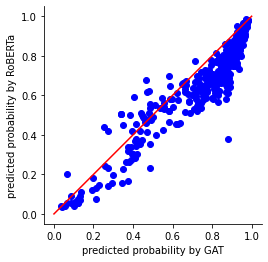

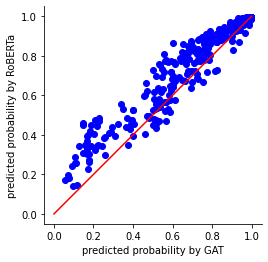

In [3]:
#plot figure 3
x1=np.array(df[(df.truth_rand==0) & (df.vali==1)].predicted_HAN_neg)
x2=np.array(df[(df.truth_rand==0) & (df.vali==1)].predicted_BERT_neg)

x3=np.array(df[(df.truth_rand==1) & (df.vali==1)].predicted_HAN_pos)
x4=np.array(df[(df.truth_rand==1) & (df.vali==1)].predicted_BERT_pos)

x1=np.array(df[(df.truth_rand==0) & (df.vali==1)].pred_han_neg_norm)
x2=np.array(df[(df.truth_rand==0) & (df.vali==1)].pred_bert_neg_norm)

x3=np.array(df[(df.truth_rand==1) & (df.vali==1)].pred_han_pos_norm)
x4=np.array(df[(df.truth_rand==1) & (df.vali==1)].pred_bert_pos_norm)


import matplotlib
import matplotlib.pyplot as plt
import numpy

os.chdir(path_result)

fig = plt.figure()
#ax = fig.add_subplot()
l1=[0,1]
#plt.plot(x2, x1)
matplotlib.pyplot.plot(x1, x2, 'bo')
matplotlib.pyplot.plot(l1, l1, 'r-')
print(numpy.corrcoef(x1, x2)[0, 1])
#matplotlib.pyplot.set_aspect('equal', 'box')
#.pyplot.gca().set_aspect('equal')
matplotlib.pyplot.axis('square')
matplotlib.pyplot.gca().spines['top'].set_visible(False)
matplotlib.pyplot.gca().spines['right'].set_visible(False)
plt.xlabel("predicted probability by GAT")
plt.ylabel("predicted probability by RoBERTa")
#ax.text(0.8, 0.1, 'Corr='+str(np.round(numpy.corrcoef(x1, x2)[0, 1],4)),bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
matplotlib.pyplot.savefig('plot3.png', dpi=300, bbox_inches='tight')


fig = plt.figure()
#ax = fig.add_subplo3t()
matplotlib.pyplot.plot(x3, x4, 'bo')
matplotlib.pyplot.plot(l1, l1, 'r-')
print(numpy.corrcoef(x3, x4)[0, 1])
matplotlib.pyplot.axis('square')
matplotlib.pyplot.gca().spines['top'].set_visible(False)
matplotlib.pyplot.gca().spines['right'].set_visible(False)
plt.xlabel("predicted probability by GAT")
plt.ylabel("predicted probability by RoBERTa")
#ax.text(0.8, 0.1, 'Corr='+str(np.round(numpy.corrcoef(x3, x4)[0, 1],4)),bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
matplotlib.pyplot.savefig('plot4.png', dpi=300, bbox_inches='tight')

In [4]:
print(len(x1))
print(len(x3))
print(n_left)
print(n_neu)
print(n_vali)

375
375
10
15
25


In [5]:
#Using logistic regression to get prediction/ensemble predicted probability 


# split into train/test sets
trainX=np.transpose(np.vstack((np.array(df.loc[(df.vali==0)]['pred_han_pos_norm'],dtype=float), 
                np.array(df.loc[(df.vali==0)]['pred_bert_pos_norm'],dtype=float))))
testX=np.transpose(np.vstack((np.array(df.loc[(df.vali==1)]['pred_han_pos_norm'],dtype=float), 
                np.array(df.loc[(df.vali==1)]['pred_bert_pos_norm'],dtype=float))))
trainy=np.array(df.loc[(df.vali==0)]['truth_rand'],dtype=float)
testy =np.array(df.loc[(df.vali==1)]['truth_rand'],dtype=float)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
w=(model.coef_[0])
weights=[]
pred=[]
#conduct prediction on each dataset
for s in schoolyears:
    # split into train/test sets
    trainX=np.transpose(np.vstack((np.array(df.loc[(df.vali==0) & (df.schoolyear==s)]['pred_han_pos_norm'],dtype=float), 
                np.array(df.loc[(df.vali==0) & (df.schoolyear==s)]['pred_bert_pos_norm'],dtype=float))))
    testX=np.transpose(np.vstack((np.array(df.loc[(df.vali==1) & (df.schoolyear==s)]['pred_han_pos_norm'],dtype=float), 
                np.array(df.loc[(df.vali==1) & (df.schoolyear==s)]['pred_bert_pos_norm'],dtype=float))))
    trainy=np.array(df.loc[(df.vali==0) & (df.schoolyear==s)]['truth_rand'],dtype=float)
    testy =np.array(df.loc[(df.vali==1) & (df.schoolyear==s)]['truth_rand'],dtype=float)
    
    a=np.transpose(np.vstack((np.array(df.loc[(df.schoolyear==s)]['pred_han_pos_norm'],dtype=float), 
                              np.array(df.loc[(df.schoolyear==s)]['pred_bert_pos_norm'],dtype=float))))
    pred+=(list(model.predict(a)))
    w1=(model.coef_[0])
    weights.append(w1[0]/(w1[0]+w1[1]))
print(weights)#weight variable is not used

[0.21559379385599078, 0.21559379385599078, 0.21559379385599078, 0.21559379385599078, 0.21559379385599078, 0.21559379385599078, 0.21559379385599078, 0.21559379385599078, 0.21559379385599078, 0.21559379385599078, 0.21559379385599078, 0.21559379385599078, 0.21559379385599078, 0.21559379385599078, 0.21559379385599078]


In [6]:
print((trainX))
print(trainy)
print(list(model.predict(a)))

[[0.98895296 0.99037193]
 [0.78105209 0.88881205]
 [0.99438973 0.99749293]
 [0.52822176 0.77448261]
 [0.99621471 0.99598498]
 [0.99475091 0.99800388]
 [0.88109275 0.92555794]
 [0.25875755 0.43863937]
 [0.36329504 0.42261806]
 [0.98650169 0.99202073]
 [0.64193975 0.78736486]
 [0.87833442 0.93382594]
 [0.99748681 0.99624579]
 [0.9779114  0.98257722]
 [0.99004842 0.97982134]
 [0.97516363 0.97082884]
 [0.99297602 0.99472638]
 [0.20713934 0.43962717]
 [0.63136457 0.64075666]
 [0.98682546 0.94240694]
 [0.90842572 0.95341328]
 [0.70292295 0.74303467]
 [0.73290831 0.70067173]
 [0.66708142 0.65644335]
 [0.94291429 0.96743487]
 [0.13995193 0.23139766]
 [0.05691152 0.23806765]
 [0.06968007 0.21038913]
 [0.05022125 0.13307254]
 [0.24397507 0.28536655]
 [0.11675289 0.31663057]
 [0.61292613 0.48907151]
 [0.29343322 0.37093259]
 [0.48326464 0.43440764]
 [0.04558445 0.09066793]
 [0.63601807 0.68018001]
 [0.54525043 0.45802599]
 [0.03570719 0.03494522]
 [0.59197761 0.7732707 ]
 [0.10771855 0.19952917]


In [7]:
#Run all previous block before running this one
#calculate metrics for ensemble model


path_result='C:\\Backup of covid project\\2cls_negVSnonneg\\results\\'
path_data="C:\\Backup of covid project\\2cls_negVSnonneg\\data\\"
path_code="C:\\Backup of covid project\\"


import numpy as np 
import urllib.request 
import os 
import csv 
import requests 
import time
import math
import rando
import pandas as pd
from collections import defaultdict
import pickle
import re, string, unicodedata
import nltk
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from string import punctuation
from autocorrect import Speller
from autocorrect import spell
import heapq
import pickle
import warnings
#from keras.preprocessing.sequence import pad_sequences
import random
from sklearn.utils import shuffle
#import tensorflow_hub as hub
#import tensorflow_text

filepath=path_result
filepath2=path_data
filepath3=path_data
path=path_data
os.chdir(filepath)

types=["comment"]
years=['2019','2020']
#years=['2020']
schools = ["notredame","uofm","columbia","UCSD","berkeley","Harvard","ucla"]
categ={"notredame":[1,1,1],"uofm":[1,1,0],"columbia":[1,0,1],"dartmouth":[0,1,1],
       "UCSD":[1,0,0],"berkeley":[0,1,0],"Harvard":[0,0,1],"ucla":[0,0,0]}

#Positive: 1, negative:0
#2020:1, 2019:0
label_group=["label"]#,"unlabel"]
months=['08','09','10','11']

att_com=['time','id','body','Emotion','emo_pred']
drop_com=["link_id",'Topic',"parent_id","author_fullname","author","gildings","score","subreddit","no_follow","total_awards_received","all_awardings","is_submitter","locked","send_replies","stickied",]
emo=["Very Positive","Positive","Neutral","Negative","Very negative"]
top=["Covid","Academics","Sports","Campus/Students Life","Social Media","Religion","Politics","Others"]

TP_HAN=[]
TN_HAN=[]
CR_HAN=[]
Pre_HAN=[]
Rec_HAN=[]
Spe_HAN=[]

TP_BERT=[]
TN_BERT=[]
CR_BERT=[]
Pre_BERT=[]
Rec_BERT=[]
Spe_BERT=[]
      
        
#Find labels from probability for three methods
df['pred_esm']=0
df['pred_HAN']=0
df['pred_BERT']=0


schoolyears=["notredame2019","notredame2020","uofm2019","uofm2020","columbia2019","columbia2020","UCSD2019","UCSD2020","berkeley2019","berkeley2020","Harvard2019","Harvard2020","ucla2019","ucla2020","dartmouth"]
      

#Analyse for classification rate for testing set

for d in range(len(df['schoolyear'])):
    negHAN=df['pred_han_neg_norm'].iloc[d]
    posHAN=df['pred_han_pos_norm'].iloc[d]
    negBERT=df['pred_bert_neg_norm'].iloc[d]
    posBERT=df['pred_bert_pos_norm'].iloc[d]
    
    if posHAN>=0.5:
        #df['pred_HAN'].iloc[d]=0
        df.iloc[d, df.columns.get_loc('pred_HAN')] =1
    elif posHAN<=0.5:
        #df['pred_HAN'].iloc[d]=1
        df.iloc[d, df.columns.get_loc('pred_HAN')] =0
    if posBERT>=0.5:
        #df['pred_BERT'].iloc[d]=0
        df.iloc[d, df.columns.get_loc('pred_BERT')] =1
    elif posBERT<=0.5:
        #df['pred_BERT'].iloc[d]=1
        df.iloc[d, df.columns.get_loc('pred_BERT')] =0
        
    df.iloc[d, df.columns.get_loc('pred_esm')]=pred[d]
        
    #below codes are for using coefficients of regression as weights!
    #weight=weights[schoolyears.index(df['schoolyear'].iloc[d])]
    #posESM=weight*posHAN+(1-weight)*posBERT
    #negESM=weight*negHAN+(1-weight)*negBERT
    #if df.iloc[d, df.columns.get_loc('pred_BERT')]==df.iloc[d, df.columns.get_loc('pred_HAN')] and df.iloc[d, df.columns.get_loc('pred_BERT')]==1:
    #    df.iloc[d, df.columns.get_loc('pred_esm')] =1
    #elif df.iloc[d, df.columns.get_loc('pred_BERT')]==df.iloc[d, df.columns.get_loc('pred_HAN')] and df.iloc[d, df.columns.get_loc('pred_BERT')]==0:
    #    df.iloc[d, df.columns.get_loc('pred_esm')] =0
    #if negESM>=posESM:
    #    #df['pred_esm'].iloc[d]=0
    #    df.iloc[d, df.columns.get_loc('pred_esm')] =0
    #elif negESM<=posESM:
    #    #df['pred_esm'].iloc[d]=1
    #    df.iloc[d, df.columns.get_loc('pred_esm')] =1
CR_HAN=[]
CR_BERT=[]
CR_esm=[]
    
F1_HAN=[]
F1_BERT=[]
F1_esm=[]

Pre_HAN=[]
Pre_BERT=[]
Pre_esm=[]

Rec_HAN=[]
Rec_BERT=[]
Rec_esm=[]

Spe_HAN=[]
Spe_BERT=[]
Spe_esm=[]
    
for s in schoolyears:
    CR_esm.append(sum(df.loc[(df.schoolyear==s) & (df.vali==k)]['truth_rand']==df.loc[(df.schoolyear==s) & (df.vali==k)]['pred_esm'])/len(df.loc[(df.schoolyear==s) & (df.vali==k)]['truth_rand']))
    CR_BERT.append(sum(df.loc[(df.schoolyear==s) & (df.vali==k)]['truth_rand']==df.loc[(df.schoolyear==s) & (df.vali==k)]['pred_BERT'])/len(df.loc[(df.schoolyear==s) & (df.vali==k)]['truth_rand']))
    CR_HAN.append(sum(df.loc[(df.schoolyear==s) & (df.vali==k)]['truth_rand']==df.loc[(df.schoolyear==s) & (df.vali==k)]['pred_HAN'])/len(df.loc[(df.schoolyear==s) & (df.vali==k)]['truth_rand']))
        
    #calculation for HAN
    Predicted_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_HAN==0)]['schoolyear'])
    Predicted_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_HAN==1)]['schoolyear'])
    Truth_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.truth_rand==0)]['schoolyear'])
    Truth_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.truth_rand==1)]['schoolyear'])
            
    False_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_HAN==1) & (df.truth_rand==0)]['schoolyear'])
    False_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_HAN==0) & (df.truth_rand==1)]['schoolyear'])
    True_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_HAN==1) & (df.truth_rand==1)]['schoolyear'])
    True_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_HAN==0) & (df.truth_rand==0)]['schoolyear'])
    
    Pre_HAN.append(True_Pos/Predicted_Pos)
    Rec_HAN.append(True_Pos/Truth_Pos)
    Spe_HAN.append(True_Neg/Truth_Neg)
    
    #calculation for BERT
    Predicted_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_BERT==0)]['schoolyear'])
    Predicted_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_BERT==1)]['schoolyear'])
    Truth_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.truth_rand==0)]['schoolyear'])
    Truth_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.truth_rand==1)]['schoolyear'])
            
    False_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_BERT==1) & (df.truth_rand==0)]['schoolyear'])
    False_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_BERT==0) & (df.truth_rand==1)]['schoolyear'])
    True_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_BERT==1) & (df.truth_rand==1)]['schoolyear'])
    True_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_BERT==0) & (df.truth_rand==0)]['schoolyear'])
    
    Pre_BERT.append(True_Pos/Predicted_Pos)
    Rec_BERT.append(True_Pos/Truth_Pos)
    Spe_BERT.append(True_Neg/Truth_Neg)
    
    #calculation for esm
    Predicted_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_esm==0)]['schoolyear'])
    Predicted_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_esm==1)]['schoolyear'])
    Truth_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.truth_rand==0)]['schoolyear'])
    Truth_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.truth_rand==1)]['schoolyear'])
            
    False_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_esm==1) & (df.truth_rand==0)]['schoolyear'])
    False_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_esm==0) & (df.truth_rand==1)]['schoolyear'])
    True_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_esm==1) & (df.truth_rand==1)]['schoolyear'])
    True_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_esm==0) & (df.truth_rand==0)]['schoolyear'])
    
    Pre_esm.append(True_Pos/Predicted_Pos)
    Rec_esm.append(True_Pos/Truth_Pos)
    Spe_esm.append(True_Neg/Truth_Neg)

CR_esm.append(sum(df.loc[(df.vali==k)]['truth_rand']==df.loc[(df.vali==k)]['pred_esm'])/len(df.loc[(df.vali==k)]['truth_rand']))
CR_BERT.append(sum(df.loc[(df.vali==k)]['truth_rand']==df.loc[(df.vali==k)]['pred_BERT'])/len(df.loc[(df.vali==k)]['truth_rand']))
CR_HAN.append(sum(df.loc[(df.vali==k)]['truth_rand']==df.loc[(df.vali==k)]['pred_HAN'])/len(df.loc[(df.vali==k)]['truth_rand']))

#calculation for HAN
Predicted_Neg=len(df.loc[(df.vali==k) & (df.pred_HAN==0)]['schoolyear'])
Predicted_Pos=len(df.loc[(df.vali==k) & (df.pred_HAN==1)]['schoolyear'])
Truth_Neg=len(df.loc[(df.vali==k) & (df.truth_rand==0)]['schoolyear'])
Truth_Pos=len(df.loc[(df.vali==k) & (df.truth_rand==1)]['schoolyear'])

False_Pos=len(df.loc[(df.vali==k) & (df.pred_HAN==1) & (df.truth_rand==0)]['schoolyear'])
False_Neg=len(df.loc[(df.vali==k) & (df.pred_HAN==0) & (df.truth_rand==1)]['schoolyear'])
True_Pos=len(df.loc[(df.vali==k) & (df.pred_HAN==1) & (df.truth_rand==1)]['schoolyear'])
True_Neg=len(df.loc[(df.vali==k) & (df.pred_HAN==0) & (df.truth_rand==0)]['schoolyear'])

Pre_HAN.append(True_Pos/Predicted_Pos)
Rec_HAN.append(True_Pos/Truth_Pos)
Spe_HAN.append(True_Neg/Truth_Neg)

#calculation for BERT
Predicted_Neg=len(df.loc[(df.vali==k) & (df.pred_BERT==0)]['schoolyear'])
Predicted_Pos=len(df.loc[(df.vali==k) & (df.pred_BERT==1)]['schoolyear'])
Truth_Neg=len(df.loc[(df.vali==k) & (df.truth_rand==0)]['schoolyear'])
Truth_Pos=len(df.loc[(df.vali==k) & (df.truth_rand==1)]['schoolyear'])

False_Pos=len(df.loc[(df.vali==k) & (df.pred_BERT==1) & (df.truth_rand==0)]['schoolyear'])
False_Neg=len(df.loc[(df.vali==k) & (df.pred_BERT==0) & (df.truth_rand==1)]['schoolyear'])
True_Pos=len(df.loc[(df.vali==k) & (df.pred_BERT==1) & (df.truth_rand==1)]['schoolyear'])
True_Neg=len(df.loc[(df.vali==k) & (df.pred_BERT==0) & (df.truth_rand==0)]['schoolyear'])

Pre_BERT.append(True_Pos/Predicted_Pos)
Rec_BERT.append(True_Pos/Truth_Pos)
Spe_BERT.append(True_Neg/Truth_Neg)

#calculation for esm
Predicted_Neg=len(df.loc[(df.vali==k) & (df.pred_esm==0)]['schoolyear'])
Predicted_Pos=len(df.loc[(df.vali==k) & (df.pred_esm==1)]['schoolyear'])
Truth_Neg=len(df.loc[(df.vali==k) & (df.truth_rand==0)]['schoolyear'])
Truth_Pos=len(df.loc[(df.vali==k) & (df.truth_rand==1)]['schoolyear'])

False_Pos=len(df.loc[(df.vali==k) & (df.pred_esm==1) & (df.truth_rand==0)]['schoolyear'])
False_Neg=len(df.loc[(df.vali==k) & (df.pred_esm==0) & (df.truth_rand==1)]['schoolyear'])
True_Pos=len(df.loc[(df.vali==k) & (df.pred_esm==1) & (df.truth_rand==1)]['schoolyear'])
True_Neg=len(df.loc[(df.vali==k) & (df.pred_esm==0) & (df.truth_rand==0)]['schoolyear'])

Pre_esm.append(True_Pos/Predicted_Pos)
Rec_esm.append(True_Pos/Truth_Pos)
Spe_esm.append(True_Neg/Truth_Neg)

F1_HAN=2*np.divide(np.multiply(Pre_HAN,Rec_HAN),np.add(Pre_HAN,Rec_HAN))
F1_BERT=2*np.divide(np.multiply(Pre_BERT,Rec_BERT),np.add(Pre_BERT,Rec_BERT))
F1_esm=2*np.divide(np.multiply(Pre_esm,Rec_esm),np.add(Pre_esm,Rec_esm))
    

print(np.round(CR_HAN,4))
print(np.round(CR_BERT,4))
print(np.round(CR_esm,4))

print(np.round(F1_HAN,4))
print(np.round(F1_BERT,4))
print(np.round(F1_esm,4))

print(np.round(Pre_HAN,4))
print(np.round(Pre_BERT,4))
print(np.round(Pre_esm,4))

print(np.round(Rec_HAN,4))
print(np.round(Rec_BERT,4))
print(np.round(Rec_esm,4))

print(np.round(Spe_HAN,4))
print(np.round(Spe_BERT,4))
print(np.round(Spe_esm,4))





[0.86   0.82   0.72   0.82   0.78   0.92   0.78   0.8    0.74   0.76
 0.92   0.8    0.9    0.78   0.82   0.8147]
[0.78   0.82   0.74   0.84   0.8    0.92   0.84   0.84   0.78   0.8
 0.94   0.78   0.86   0.82   0.78   0.8227]
[0.82   0.86   0.72   0.84   0.82   0.92   0.82   0.82   0.76   0.78
 0.94   0.78   0.88   0.8    0.84   0.8267]
[0.8627 0.8163 0.72   0.8302 0.7843 0.92   0.7556 0.8077 0.7636 0.75
 0.92   0.8    0.898  0.7755 0.8364 0.8164]
[0.7843 0.8302 0.7347 0.8462 0.8    0.92   0.8095 0.84   0.8    0.7826
 0.9388 0.7843 0.8511 0.8302 0.8    0.8234]
[0.8163 0.8627 0.7083 0.8462 0.8163 0.92   0.7907 0.8235 0.7778 0.7556
 0.9388 0.7843 0.8696 0.8    0.8462 0.8243]
[0.8462 0.8333 0.72   0.7857 0.7692 0.92   0.85   0.7778 0.7    0.7826
 0.92   0.8    0.9167 0.7917 0.7667 0.8089]
[0.7692 0.7857 0.75   0.8148 0.8    0.92   1.     0.84   0.7333 0.8571
 0.9583 0.7692 0.9091 0.7857 0.7333 0.8201]
[0.8333 0.8462 0.7391 0.8148 0.8333 0.92   0.9444 0.8077 0.7241 0.85
 0.9583 0.7692 0.952

In [174]:
#make it clearer

sc=['metric','method',"notredame2019","notredame2020","uofm2019","uofm2020","columbia2019","columbia2020","UCSD2019","UCSD2020","berkeley2019","berkeley2020","Harvard2019","Harvard2020","ucla2019","ucla2020","dartmouth",'overall']

dat=[['CR']+['HAN']+[str(c) for c in CR_HAN]]
line=['CR']+['BERT']+[str(c) for c in CR_BERT];dat.append(line);
line=['CR']+['esm']+[str(c) for c in CR_esm];dat.append(line);

line=['F1']+['HAN']+[str(c) for c in F1_HAN];dat.append(line);
line=['F1']+['BERT']+[str(c) for c in F1_BERT];dat.append(line);
line=['F1']+['esm']+[str(c) for c in F1_esm];dat.append(line);

line=['Pre']+['HAN']+[str(c) for c in Pre_HAN];dat.append(line);
line=['Pre']+['BERT']+[str(c) for c in Pre_BERT];dat.append(line);
line=['Pre']+['esm']+[str(c) for c in Pre_esm];dat.append(line);

line=['Rec']+['HAN']+[str(c) for c in Rec_HAN];dat.append(line);
line=['Rec']+['BERT']+[str(c) for c in Rec_BERT];dat.append(line);
line=['Rec']+['esm']+[str(c) for c in Rec_esm];dat.append(line);

line=['Spe']+['HAN']+[str(c) for c in Spe_HAN];dat.append(line);
line=['Spe']+['BERT']+[str(c) for c in Spe_BERT];dat.append(line);
line=['Spe']+['esm']+[str(c) for c in Spe_esm];dat.append(line);

#print(dat)
dff=pd.DataFrame(dat,columns=sc)
os.chdir(path_result)
#dff.to_csv(path_result+'figure4.csv', index = False, header=True)


dff.drop(dff[dff.method=='HAN'].index, inplace = True)
dff.drop(dff[dff.method=='BERT'].index, inplace = True)
print(dff)
dd = dff[['ucla2019','ucla2020','UCSD2019','UCSD2020','berkeley2019','berkeley2020','uofm2019','uofm2020',
         'Harvard2019','Harvard2020','columbia2019','columbia2020','dartmouth','notredame2019','notredame2020']]
#dd=list(dd.transpose())

   metric method       notredame2019       notredame2020            uofm2019  \
2      CR    esm                0.82                0.86                0.72   
5      F1    esm   0.816326530612245  0.8627450980392156  0.7083333333333334   
8     Pre    esm  0.8333333333333334  0.8461538461538461  0.7391304347826086   
11    Rec    esm                 0.8                0.88                0.68   
14    Spe    esm                0.84                0.84                0.76   

              uofm2020        columbia2019 columbia2020            UCSD2019  \
2                 0.84                0.82         0.92                0.82   
5   0.8461538461538461   0.816326530612245         0.92  0.7906976744186047   
8   0.8148148148148148  0.8333333333333334         0.92  0.9444444444444444   
11                0.88                 0.8         0.92                0.68   
14                 0.8                0.84         0.92                0.96   

              UCSD2020        berkeley2019  

In [188]:
ol=dd.transpose().values.tolist()
for i in range(len(ol)):
    for j in range(len(ol[i])):
        ol[i][j]=str(np.round(float(ol[i][j]),2))
for i in ol:
    print(' &'.join(i))

0.88 &0.87 &0.95 &0.8 &0.96
0.8 &0.8 &0.8 &0.8 &0.8
0.82 &0.79 &0.94 &0.68 &0.96
0.82 &0.82 &0.81 &0.84 &0.8
0.76 &0.78 &0.72 &0.84 &0.68
0.78 &0.76 &0.85 &0.68 &0.88
0.72 &0.71 &0.74 &0.68 &0.76
0.84 &0.85 &0.81 &0.88 &0.8
0.94 &0.94 &0.96 &0.92 &0.96
0.78 &0.78 &0.77 &0.8 &0.76
0.82 &0.82 &0.83 &0.8 &0.84
0.92 &0.92 &0.92 &0.92 &0.92
0.84 &0.85 &0.81 &0.88 &0.8
0.82 &0.82 &0.83 &0.8 &0.84
0.86 &0.86 &0.85 &0.88 &0.84


In [198]:
#after getting GLMM_esm.csv, use this piece of code to get the proportion of neg in 2019 and 2020


import os
import pandas as pd

os.chdir("C:\\Backup of covid project\\2cls_negVSnonneg\\results\\")
new=pd.read_csv("GLMM_esm.csv",skip_blank_lines=True,header=None)
os.chdir("C:\\Backup of covid project\\2cls_negVSnonneg\\results\\")
old=pd.read_csv("GLMM_esm_0.5.csv",skip_blank_lines=True,header=None)
new.columns = new.columns.map(str)
old.columns = old.columns.map(str)

#new[(new.0==0) and (new.1==0)]
new.rename({'0':'nonneg','1':'year2020','2':'inperson','3':'small','4':'private','5':'school'},axis=1,inplace=True)
old.rename({'0':'nonneg','1':'year2020','2':'inperson','3':'small','4':'private','5':'school'},axis=1,inplace=True)
#old.set_axis(['nonneg', 'year2020', 'inperson','small','private','school'],axis=1,inplace=False)
#df_new=data.frame()
#df['2019']=[]
NN=(len(new[(new.nonneg==0) & (new.year2020==0)]))
NP=(len(new[(new.nonneg==0) & (new.year2020==1)]))
PN=(len(new[(new.nonneg==1) & (new.year2020==0)]))
PP=(len(new[(new.nonneg==1) & (new.year2020==1)]))

print(NN/PN-NP/PP)
NN=(len(old[(old.nonneg==0) & (old.year2020==0)]))
NP=(len(old[(old.nonneg==0) & (old.year2020==1)]))
PN=(len(old[(old.nonneg==1) & (old.year2020==0)]))
PP=(len(old[(old.nonneg==1) & (old.year2020==1)]))
print(NN/PN-NP/PP)

print(len(new[(new.nonneg==0) & (new.year2020==0)]))
print(len(new[(new.nonneg==0) & (new.year2020==1)]))
print(len(new[(new.nonneg==1) & (new.year2020==0)]))
print(len(new[(new.nonneg==1) & (new.year2020==1)]))


-0.03231244374008929
-0.04285964789988228
19672
25976
91146
104682


In [8]:
#process ensemble results to data that's ready for GLMM
#This script is only for neg VS nonneg
#pos in this script means non-neg
#run all previous block before running this one

path_result='C:\\Backup of covid project\\2cls_negVSnonneg\\results\\'
path_data="C:\\Backup of covid project\\2cls_negVSnonneg\\data\\"
path_code="C:\\Backup of covid project\\"


import numpy as np 
import urllib.request 
import os 
import csv 
import requests 
import time
import math
import rando
import pandas as pd
from collections import defaultdict
import pickle
import re, string, unicodedata
import nltk
import contractions
import inflect
import heapq
import pickle
import warnings
#from keras.preprocessing.sequence import pad_sequences
import random
from sklearn.utils import shuffle
#import tensorflow_hub as hub
#import tensorflow_text

os.chdir(path_data)

types=["comment"]
years=['2019','2020']
#years=['2020']
schools = ["notredame","uofm","columbia","UCSD","berkeley","Harvard","ucla"]
categ={"notredame":[1,1,1],"uofm":[1,1,0],"columbia":[1,0,1],"dartmouth":[0,1,1],
       "UCSD":[1,0,0],"berkeley":[0,1,0],"Harvard":[0,0,1],"ucla":[0,0,0]}

#non-Neg: 1, negative:0
#2020:1, 2019:0
label_group=["label","unlabel"]
months=['08','09','10','11']

att_com=['time','id','body','Emotion','emo_pred']
drop_com=["link_id",'Topic',"parent_id","author_fullname","author","gildings","score","subreddit","no_follow","total_awards_received","all_awardings","is_submitter","locked","send_replies","stickied",]
emo=["Very Positive","Positive","Neutral","Negative","Very negative"]
top=["Covid","Academics","Sports","Campus/Students Life","Social Media","Religion","Politics","Others"]


df_all = pd.DataFrame(columns = ['Emotion','predicted_HAN_neg','predicted_HAN_pos','predicted_BERT_neg','predicted_BERT_pos','truth_label','truth_rand','school','year','schoolyear'])
#Positive: 1, negative:0
ii=0
for t in types:
    for s in schools:
        for y in years:
            print(ii)
            ii+=1
            f=s+y+'.p'
            os.chdir(path_result)
            predicted=pickle.load(open(f,'rb'))
            from scipy.special import softmax
            m=softmax(predicted,axis=1)
            pred_HAN=m
            
            f="label_emt3_"+s+y+"_cm.csv"
            os.chdir(path_data)
            rand_truth1=pd.read_csv(f,skip_blank_lines=True, header=None)#.values
            rand_truth=np.argmax(rand_truth1.values,axis=1)
                
            data = pd.DataFrame(columns = ['Emotion'])
            predicted = pd.DataFrame(columns = ['emo_pred_neg','emo_pred_pos'])
            
            for l in label_group:
                f=s+t+y+l+".csv"
                os.chdir(path_data)
                dat=pd.read_csv(f,skip_blank_lines=True)
                data=data.append(dat,ignore_index = True)

                f=s+t+y+l+'_score.csv'
                os.chdir(path_data)
                predicted1=pd.read_csv(f,skip_blank_lines=True)
                predicted=predicted.append(predicted1[['emo_pred_neg','emo_pred_pos']],ignore_index = True)
            
            predicted=predicted[['emo_pred_neg','emo_pred_pos']].values
            for i in range(len(predicted)):
                p0=predicted[i,0]
                #predicted[i,0]=p[0]/(p[0]+p[1])
                predicted[i,1]=1-p0
            pred_BERT=predicted

            w=data
            w['predicted_HAN_neg']=pred_HAN[:,0]
            w['predicted_HAN_pos']=pred_HAN[:,1]
            w['predicted_BERT_neg']=pred_BERT[:,0]
            w['predicted_BERT_pos']=pred_BERT[:,1]

            orig_truth=[]
            for e in w['Emotion'].values:
                if e=='Negative' or e=='Very negative':
                    orig_truth.append(0)
                elif e=='Positive' or e=='Very Positive':
                    orig_truth.append(1)
                elif e=='Neutral':
                    orig_truth.append(2)
                else:
                    orig_truth.append(3)
            w['truth_label']=np.array(orig_truth)
            w['truth_rand']=rand_truth
            w['schoolyear']=s+y
            w['school']=s
            w['year']=y
            df_all = df_all.append(w,ignore_index = True)

print(ii)
ii+=1
#append dartmouth to df
s='dartmouth'
f=s+'.p'
os.chdir(path_result)
predicted=pickle.load(open(f,'rb'))
m=softmax(predicted,axis=1)
pred_HAN=m

f=s+t+'_score.csv'
os.chdir(path_data)
predicted=pd.read_csv(f,skip_blank_lines=True)
predicted=predicted[['emo_pred_neg','emo_pred_pos']].values
for i in range(len(predicted)):
    p0=predicted[i,0]
    #predicted[i,0]=p[0]/(p[0]+p[1])
    predicted[i,1]=1-p0
pred_BERT=predicted

print(1)
f1='dartmouthcomment2019label.csv'
f2='dartmouthcomment2019unlabel.csv'
f3='dartmouthcomment2020label.csv'
f4='dartmouthcomment2020unlabel.csv'
os.chdir(path_data)
data1=pd.read_csv(f1,skip_blank_lines=True)
data1=data1.drop(drop_com, axis=1)
data1['year']='2019'
data2=pd.read_csv(f2,skip_blank_lines=True)
data2=data2.drop(drop_com, axis=1)
data2['year']='2019'
data3=pd.read_csv(f3,skip_blank_lines=True)
data3=data3.drop(drop_com, axis=1)
data3['year']='2020'
data4=pd.read_csv(f4,skip_blank_lines=True)
data4=data4.drop(drop_com, axis=1)
data4['year']='2020'
data = pd.concat([data1,data2,data3,data4], axis=0).reset_index(drop=True)
data=data[['Emotion','year']]

print(2)
f="label_emt3_"+s+"_cm.csv"
os.chdir(path_data)
rand_truth1=pd.read_csv(f,skip_blank_lines=True, header=None)#.values
rand_truth=np.argmax(rand_truth1.values,axis=1)

print(3)
w=data
w['predicted_HAN_neg']=pred_HAN[:,0]
w['predicted_HAN_pos']=pred_HAN[:,1]
w['predicted_BERT_neg']=pred_BERT[:,0]
w['predicted_BERT_pos']=pred_BERT[:,1]

print(4)
orig_truth=[]
for e in w['Emotion'].values:
    if e=='Negative' or e=='Very negative':
        orig_truth.append(0)
    elif e=='Positive' or e=='Very Positive':
        orig_truth.append(1)
    elif e=='Neutral':
        orig_truth.append(2)
    else:
        orig_truth.append(3)
w['truth_label']=np.array(orig_truth)
w['truth_rand']=rand_truth
w['schoolyear']=s
w['school']=s
#w['year']=y
df_all = df_all.append(w,ignore_index = True)


#normalize all probability using cut0ff!

df_all['pred_han_neg_norm']=int(0)
df_all['pred_han_pos_norm']=int(0)
df_all['pred_bert_neg_norm']=int(0)
df_all['pred_bert_pos_norm']=int(0)

for d in range(len(df_all['body'])):
    if df_all.iloc[d]['predicted_HAN_pos']>=cutoff_han:
        newpos=0.5*(df_all.iloc[d]['predicted_HAN_pos']-cutoff_han)/(1-cutoff_han)+0.5
    elif df_all.iloc[d]['predicted_HAN_pos']<cutoff_han:
        newpos=0.5*df_all.iloc[d]['predicted_HAN_pos']/cutoff_han
    df_all.iloc[d, df_all.columns.get_loc('pred_han_pos_norm')]=newpos
    df_all.iloc[d, df_all.columns.get_loc('pred_han_neg_norm')]=1-newpos
    
    if df_all.iloc[d]['predicted_BERT_pos']>=cutoff_bert:
        newpos=0.5*(df_all.iloc[d]['predicted_BERT_pos']-cutoff_bert)/(1-cutoff_bert)+0.5
    elif df_all.iloc[d]['predicted_BERT_pos']<cutoff_bert:
        newpos=0.5*df_all.iloc[d]['predicted_BERT_pos']/cutoff_bert
    df_all.iloc[d, df_all.columns.get_loc('pred_bert_pos_norm')]=newpos
    df_all.iloc[d, df_all.columns.get_loc('pred_bert_neg_norm')]=1-newpos
print(d)
#(df)#.iloc[1])#['predicted_HAN_neg'])



path_result='C:\\Backup of covid project\\2cls_negVSnonneg\\results\\'
path_data="C:\\Backup of covid project\\2cls_negVSnonneg\\data\\"
path_code="C:\\Backup of covid project\\"

import numpy as np 
import urllib.request 
import os 
import csv 
import requests 
import time
import math
import rando
import pandas as pd
from collections import defaultdict
import pickle
import re, string, unicodedata
import nltk
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from string import punctuation
from autocorrect import Speller
from autocorrect import spell
import heapq
import pickle
import warnings
#from keras.preprocessing.sequence import pad_sequences
import random
from sklearn.utils import shuffle
#import tensorflow_hub as hub
#import tensorflow_text

filepath=path_result
filepath2=path_data
filepath3=path_data
path=path_data
os.chdir(filepath)

types=["comment"]
years=['2019','2020']
#years=['2020']
schools = ["notredame","uofm","columbia","UCSD","berkeley","Harvard","ucla"]
categ={"notredame":[1,1,1],"uofm":[1,1,0],"columbia":[1,0,1],"dartmouth":[0,1,1],
       "UCSD":[1,0,0],"berkeley":[0,1,0],"Harvard":[0,0,1],"ucla":[0,0,0]}

#Positive: 1, negative:0
#2020:1, 2019:0
label_group=["label"]#,"unlabel"]
months=['08','09','10','11']

att_com=['time','id','body','Emotion','emo_pred']
drop_com=["link_id",'Topic',"parent_id","author_fullname","author","gildings","score","subreddit","no_follow","total_awards_received","all_awardings","is_submitter","locked","send_replies","stickied",]
emo=["Very Positive","Positive","Neutral","Negative","Very negative"]
top=["Covid","Academics","Sports","Campus/Students Life","Social Media","Religion","Politics","Others"]

df = pd.DataFrame(columns = ['body','Emotion','predicted_HAN_neg','predicted_HAN_pos','predicted_BERT_neg','predicted_BERT_pos','truth_label','truth_rand','schoolyear'])
#Positive: 1, negative:0
for t in types:
    for s in schools:
        for y in years:
            for l in label_group:
                f=s+y+'.p'
                os.chdir(path_result)
                predicted=pickle.load(open(f,'rb'))
                from scipy.special import softmax
                m=softmax(predicted,axis=1)
                pred_HAN=m

                f=s+t+y+'label_score.csv'
                os.chdir(path_data)
                predicted=pd.read_csv(f,skip_blank_lines=True)
                predicted=predicted[['emo_pred_neg','emo_pred_pos']].values
                for i in range(len(predicted)):
                    p0=predicted[i,0]
                    #p1=predicted[i,1]
                    #predicted[i,0]=p0/(p0+p1)
                    predicted[i,1]=1-p0
                pred_BERT=predicted

                f=s+t+y+l+".csv"
                os.chdir(path_data)
                data=pd.read_csv(f,skip_blank_lines=True)
                data=data[['body','Emotion']]

                f="test_index_"+s+y+"_cm.p"
                os.chdir(path_data)
                test_index=pickle.load(open(f,'rb'))

                f="label_emt3_"+s+y+"_cm.csv"
                os.chdir(path_data)
                rand_truth1=pd.read_csv(f,skip_blank_lines=True, header=None)#.values
                rand_truth=np.argmax(rand_truth1.values,axis=1)

                w=data.loc[test_index]
                w['predicted_HAN_neg']=pred_HAN[test_index,0]
                w['predicted_HAN_pos']=pred_HAN[test_index,1]
                w['predicted_BERT_neg']=pred_BERT[test_index,0]
                w['predicted_BERT_pos']=pred_BERT[test_index,1]

                orig_truth=[]
                clas_truth=[]
                for e in w['Emotion'].values:
                    if e=='Negative' or e=='Very negative':
                        orig_truth.append(0)
                        clas_truth.append(0)
                    elif e=='Positive' or e=='Very Positive':
                        orig_truth.append(1)
                        clas_truth.append(1)
                    elif e=='Neutral':
                        orig_truth.append(2)
                        clas_truth.append(1)
                w['truth_label']=np.array(orig_truth)
                w['truth_rand']=np.array(clas_truth)
                w['schoolyear']=s+y
                df = df.append(w,ignore_index = True)

#append dartmouth  to df
s='dartmouth'
f=s+'.p'
os.chdir(path_result)
predicted=pickle.load(open(f,'rb'))
m=softmax(predicted,axis=1)
pred_HAN=m

f=s+t+'_score.csv'
os.chdir(path_data)
predicted=pd.read_csv(f,skip_blank_lines=True)#,header=None)
#predicted.columns = predicted.columns.astype(str)
#predicted.rename(columns={"6": "emo_pred_pos", "7": "emo_pred_neu","8": "emo_pred_neg"}, inplace = True)
predicted=predicted[['emo_pred_neg','emo_pred_pos']].values
for i in range(len(predicted)):
    p0=predicted[i,0]
    #p1=predicted[i,1]
    #predicted[i,0]=p0/(p0+p1)
    predicted[i,1]=1-p0
pred_BERT=predicted

f1='dartmouthcomment2019label.csv'
f2='dartmouthcomment2019unlabel.csv'
f3='dartmouthcomment2020label.csv'
f4='dartmouthcomment2020unlabel.csv'
os.chdir(path_data)
data1=pd.read_csv(f1,skip_blank_lines=True)
data1=data1.drop(drop_com, axis=1)
data2=pd.read_csv(f2,skip_blank_lines=True)
data2=data2.drop(drop_com, axis=1)
data3=pd.read_csv(f3,skip_blank_lines=True)
data3=data3.drop(drop_com, axis=1)
data4=pd.read_csv(f4,skip_blank_lines=True)
data4=data4.drop(drop_com, axis=1)
data = pd.concat([data1,data2,data3,data4], axis=0).reset_index(drop=True)
data=data[['body','Emotion']]

f="test_index_"+s+"_cm.p"
os.chdir(path_data)
test_index=pickle.load(open(f,'rb'))

f="label_emt3_"+s+"_cm.csv"
os.chdir(path_data)
rand_truth1=pd.read_csv(f,skip_blank_lines=True, header=None)#.values
rand_truth=np.argmax(rand_truth1.values,axis=1)

w=data.loc[test_index]
w['predicted_HAN_neg']=pred_HAN[test_index,0]
w['predicted_HAN_pos']=pred_HAN[test_index,1]
w['predicted_BERT_neg']=pred_BERT[test_index,0]
w['predicted_BERT_pos']=pred_BERT[test_index,1]

orig_truth=[]
for e in w['Emotion'].values:
    if e=='Negative' or e=='Very negative':
        orig_truth.append(0)
    elif e=='Positive' or e=='Very Positive':
        orig_truth.append(1)
    elif e=='Neutral':
        orig_truth.append(2)
w['truth_label']=np.array(orig_truth)
w['truth_rand']=rand_truth[test_index]
w['schoolyear']=s
df = df.append(w,ignore_index = True)

#Define the validation dataset
#kfold=5#k fold validation, need to be divisible by 50
df['vali']=int(0)
schoolyears=["notredame2019","notredame2020","uofm2019","uofm2020","columbia2019","columbia2020","UCSD2019","UCSD2020","berkeley2019","berkeley2020","Harvard2019","Harvard2020","ucla2019","ucla2020","dartmouth"]

#vali==1 means its testing set instead of validation set!
k=1
n_vali=25#best
n_neu=int(31*n_vali/50)
n_left=n_vali-n_neu
v_neg=np.array([n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali])
v_neu=np.array([n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu])
v_pos=np.array([n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left])
for d in range(len(df['schoolyear'])):
    if df['truth_label'].iloc[d]==0 and v_neg[schoolyears.index(df['schoolyear'].iloc[d])]>0:
        df.at[d, 'vali']=int(k);
        v_neg[schoolyears.index(df['schoolyear'].iloc[d])]-=1
    elif df['truth_label'].iloc[d]==1 and v_pos[schoolyears.index(df['schoolyear'].iloc[d])]>0:
        df.at[d, 'vali']=int(k);
        v_pos[schoolyears.index(df['schoolyear'].iloc[d])]-=1
    elif df['truth_label'].iloc[d]==2 and v_neu[schoolyears.index(df['schoolyear'].iloc[d])]>0:
        df.at[d, 'vali']=int(k);
        v_neu[schoolyears.index(df['schoolyear'].iloc[d])]-=1
    
    
df['pred_han_neg_norm']=int(0)
df['pred_han_pos_norm']=int(0)
df['pred_bert_neg_norm']=int(0)
df['pred_bert_pos_norm']=int(0)

for d in range(len(df['body'])):
    if df.iloc[d]['predicted_HAN_pos']>=cutoff_han:
        newpos=0.5*(df.iloc[d]['predicted_HAN_pos']-cutoff_han)/(1-cutoff_han)+0.5
    elif df.iloc[d]['predicted_HAN_pos']<cutoff_han:
        newpos=0.5*df.iloc[d]['predicted_HAN_pos']/cutoff_han
    df.iloc[d, df.columns.get_loc('pred_han_pos_norm')]=newpos
    df.iloc[d, df.columns.get_loc('pred_han_neg_norm')]=1-newpos
    
    if df.iloc[d]['predicted_BERT_pos']>=cutoff_bert:
        newpos=0.5*(df.iloc[d]['predicted_BERT_pos']-cutoff_bert)/(1-cutoff_bert)+0.5
    elif df.iloc[d]['predicted_BERT_pos']<cutoff_bert:
        newpos=0.5*df.iloc[d]['predicted_BERT_pos']/cutoff_bert
    df.iloc[d, df.columns.get_loc('pred_bert_pos_norm')]=newpos
    df.iloc[d, df.columns.get_loc('pred_bert_neg_norm')]=1-newpos
print(d)    
    
    
    

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
df_all['pred_esm']=0
df_all['pred_HAN']=0
df_all['pred_BERT']=0

pred=[]
for s in schoolyears:
    # split into train/test sets
    trainX=np.transpose(np.vstack((np.array(df.loc[(df.vali==0) & (df.schoolyear==s)]['pred_han_pos_norm'],dtype=float), 
                np.array(df.loc[(df.vali==0) & (df.schoolyear==s)]['pred_bert_pos_norm'],dtype=float))))
    testX=np.transpose(np.vstack((np.array(df.loc[(df.vali==1) & (df.schoolyear==s)]['pred_han_pos_norm'],dtype=float), 
                np.array(df.loc[(df.vali==1) & (df.schoolyear==s)]['pred_bert_pos_norm'],dtype=float))))
    trainy=np.array(df.loc[(df.vali==0) & (df.schoolyear==s)]['truth_rand'],dtype=float)
    testy =np.array(df.loc[(df.vali==1) & (df.schoolyear==s)]['truth_rand'],dtype=float)
    # fit a model
    model = LogisticRegression(solver='lbfgs')#,fit_intercept=False)
    model.fit(trainX, trainy)
    a=np.transpose(np.vstack((np.array(df_all.loc[(df_all.schoolyear==s)]['pred_han_pos_norm'],dtype=float), 
                              np.array(df_all.loc[(df_all.schoolyear==s)]['pred_bert_pos_norm'],dtype=float))))
    #df_all.iloc[d, df_all.columns.get_loc('pred_esm')]=pred[d]
    pred+=(list(model.predict(a)))
    





schoolyears=["notredame2019","notredame2020","uofm2019","uofm2020","columbia2019","columbia2020","UCSD2019","UCSD2020","berkeley2019","berkeley2020","Harvard2019","Harvard2020","ucla2019","ucla2020","dartmouth"]        
#Find the label of different algorithm
#weights=[0.45327492615644743, 0.49308511163861135, 0.43351595733428544, 0.43300038014780345, 0.39302524195709027, 0.4356421495765769, 0.4885322852784118, 0.44138590918593695, 0.4986561524350483, 0.42531661650389796, 0.4644081224276331, 0.5078550666562274, 0.4904802793753473, 0.442666493138592, 0.5362901195505035]
for d in range(len(df_all['schoolyear'])):
    if (d/1000-int(d/1000))==0:
        print(d)
    negHAN=df_all['pred_han_neg_norm'].iloc[d]
    posHAN=df_all['pred_han_pos_norm'].iloc[d]
    negBERT=df_all['pred_bert_neg_norm'].iloc[d]
    posBERT=df_all['pred_bert_pos_norm'].iloc[d]
    if posHAN>=0.5:
        #df['pred_HAN'].iloc[d]=0
        df_all.iloc[d, df_all.columns.get_loc('pred_HAN')] =1
    elif posHAN<=0.5:
        #df['pred_HAN'].iloc[d]=1
        df_all.iloc[d, df_all.columns.get_loc('pred_HAN')] =0
    if posBERT>=0.5:
        #df['pred_BERT'].iloc[d]=0
        df_all.iloc[d, df_all.columns.get_loc('pred_BERT')] =1
    elif posBERT<=0.5:
        #df['pred_BERT'].iloc[d]=1
        df_all.iloc[d, df_all.columns.get_loc('pred_BERT')] =0
    
    df_all.iloc[d, df_all.columns.get_loc('pred_esm')]=pred[d]

        

 
        
        
os.chdir(path_data)

types=["comment"]
years=['2019','2020']
#years=['2020']
schools = ["notredame","uofm","columbia","dartmouth","UCSD","berkeley","Harvard","ucla"]
categ={"notredame":[1,1,1],"uofm":[1,1,0],"columbia":[1,0,1],"dartmouth":[0,1,1],
       "UCSD":[1,0,0],"berkeley":[0,1,0],"Harvard":[0,0,1],"ucla":[0,0,0]}

#Time period: Aug to Nov 2019 (baseline) and  Aug to Nov. 2020;
#A in person learning 1; others (online, hybrid) 0
#B small city 1, large city 0
#C private 1, public 0
#   A  B  C 
#1  1  1  1  
#2  1  1  0 
#3  1  0  1   
#4  0  1  1
#5  1  0  0   
#6  0  1  0 
#7  0  0  1   
#8  0  0  0  

#1 Notre Dame (in-person learning 1, small city 1, private 1)
#2  Michigan   ( in-person learning  1,  small city 1, public 0)
#3. Columbia   ( in-person  1, large city 0, private 1) 
#4. Dartmouth  (online 0,  small city 1, private 1)
#5  UCSD (in-person learning 1,  large city 0 , public 0)  
#6  xxx   (0 online  small city 1, public 0)  
#7  Harvard    (online 0,  large city 0, private 1)
#8  UCLA (online 0,  large city 0, public 0)

#non-Neg: 1, negative:0
#2020:1, 2019:0
label_group=["label","unlabel"]
months=['08','09','10','11']

att_com=['time','id','body','Emotion','Topic','emo_pred']
emo=["Very Positive","Positive","Neutral","Negative","Very negative"]
top=["Covid","Academics","Sports","Campus/Students Life","Social Media","Religion","Politics","Others"]

#non-Neg: 1, negative:0
for d in range(len(df_all["schoolyear"])):
    if (d/1000-int(d/1000))==0:
        print(d)
    y=df_all['year'][d]
    s=df_all['school'][d]
    #sentence=data["body"][d]
    #emb=np.array(use(sentence))[0]
    line=[df_all["pred_esm"][d]]
    line.append(int(y=='2020'))
    if categ[s][0]==1:
        line.append(1)
    elif categ[s][0]==0:
        if y=='2020':
            line.append(0)
        elif y=='2019':
            line.append(1)
    line.append(categ[s][1])
    line.append(categ[s][2])
    line.append(schools.index(s))
    #line=line+emb.tolist()
    name='GLMM_esm.csv'
    os.chdir(path_result)
    e=open(name, 'a',newline='')
    with e:
        writer = csv.writer(e, delimiter=',')
        writer.writerow(line)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1
2
3
4
120737
1499
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37

In [10]:
#get GLMM ready data for BERT and RoBERTa, respectively

os.chdir(path_data)

types=["comment"]
years=['2019','2020']
#years=['2020']
schools = ["notredame","uofm","columbia","dartmouth","UCSD","berkeley","Harvard","ucla"]
categ={"notredame":[1,1,1],"uofm":[1,1,0],"columbia":[1,0,1],"dartmouth":[0,1,1],
       "UCSD":[1,0,0],"berkeley":[0,1,0],"Harvard":[0,0,1],"ucla":[0,0,0]}

#Time period: Aug to Nov 2019 (baseline) and  Aug to Nov. 2020;
#A in person learning 1; others (online, hybrid) 0
#B small city 1, large city 0
#C private 1, public 0
#   A  B  C 
#1  1  1  1  
#2  1  1  0 
#3  1  0  1   
#4  0  1  1
#5  1  0  0   
#6  0  1  0 
#7  0  0  1   
#8  0  0  0  

#1 Notre Dame (in-person learning 1, small city 1, private 1)
#2  Michigan   ( in-person learning  1,  small city 1, public 0)
#3. Columbia   ( in-person  1, large city 0, private 1) 
#4. Dartmouth  (online 0,  small city 1, private 1)
#5  UCSD (in-person learning 1,  large city 0 , public 0)  
#6  xxx   (0 online  small city 1, public 0)  
#7  Harvard    (online 0,  large city 0, private 1)
#8  UCLA (online 0,  large city 0, public 0)

#Positive: 1, negative:0
#2020:1, 2019:0
label_group=["label","unlabel"]
months=['08','09','10','11']

att_com=['time','id','body','Emotion','Topic','emo_pred']
emo=["Very Positive","Positive","Neutral","Negative","Very negative"]
top=["Covid","Academics","Sports","Campus/Students Life","Social Media","Religion","Politics","Others"]

#non-Neg: 1, negative:0
for d in range(len(df_all["schoolyear"])):
    if (d/1000-int(d/1000))==0:
        print(d)
    y=df_all['year'][d]
    s=df_all['school'][d]
    
    line=[df_all["pred_HAN"][d]]
    line.append(int(y=='2020'))
    if categ[s][0]==1:
        line.append(1)
    elif categ[s][0]==0:
        if y=='2020':
            line.append(0)
        elif y=='2019':
            line.append(1)
    line.append(categ[s][1])
    line.append(categ[s][2])
    line.append(schools.index(s))
    name='GLMM_esm_han.csv'
    os.chdir(path_result)
    e=open(name, 'a',newline='')
    with e:
        writer = csv.writer(e, delimiter=',')
        writer.writerow(line)

        
for d in range(len(df_all["schoolyear"])):
    if (d/1000-int(d/1000))==0:
        print(d)
    y=df_all['year'][d]
    s=df_all['school'][d]
    line=[df_all["pred_BERT"][d]]
    line.append(int(y=='2020'))
    if categ[s][0]==1:
        line.append(1)
    elif categ[s][0]==0:
        if y=='2020':
            line.append(0)
        elif y=='2019':
            line.append(1)
    line.append(categ[s][1])
    line.append(categ[s][2])
    line.append(schools.index(s))
    name='GLMM_esm_bert.csv'
    os.chdir(path_result)
    e=open(name, 'a',newline='')
    with e:
        writer = csv.writer(e, delimiter=',')
        writer.writerow(line)
#df_all

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
460

In [190]:
import tensorflow as tf
print(tf. __version__)

1.15.4
